# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [31]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from mogp import MultiOutputMarginal
from util import build_XY

In [32]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [33]:
N = 50
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [34]:
train_x.shape, train_y.shape

((50,), (50, 3))

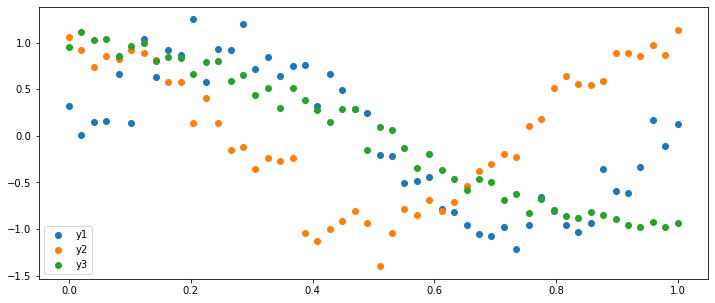

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [36]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [37]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 50)

In [38]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((50, 1), (150, 2), (150, 1))

In [39]:
M = 80
x_new = np.linspace(-0.5, 1.5, M)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [40]:
X_new.shape

(240, 2)

### ICM: one kernel

In [41]:
import aesara.tensor as at

In [42]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    
    W = np.random.rand(3,2) # (n_outputs, w_rank)
    kappa = np.random.rand(3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], input_dim=2, active_dims=[1], num_outputs=3, B=B)
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

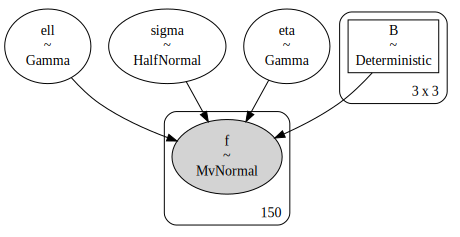

In [43]:
pm.model_to_graphviz(model)

In [44]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 14 seconds.


CPU times: user 48.7 s, sys: 1min 7s, total: 1min 56s
Wall time: 18.1 s


In [45]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 23.6 s, sys: 28 s, total: 51.6 s
Wall time: 7.61 s


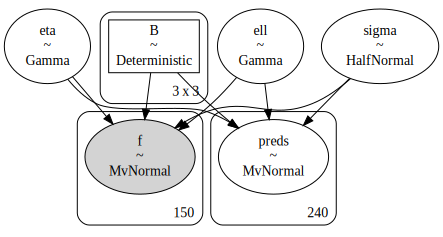

In [46]:
pm.model_to_graphviz(model)

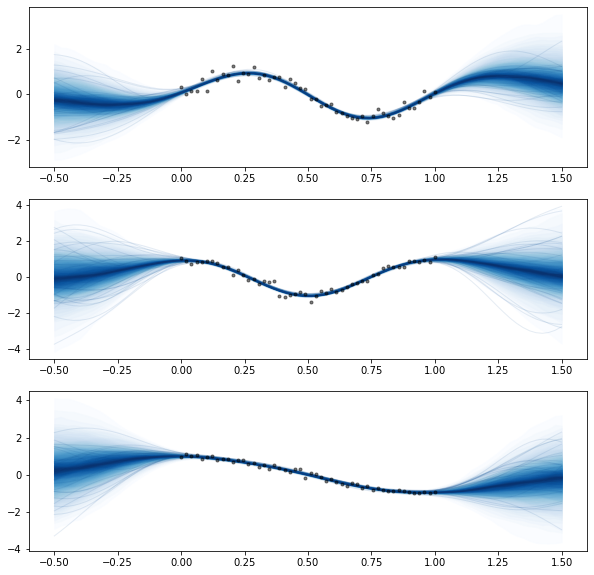

In [47]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [48]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ell,0.300,0.038,0.227,0.366,0.003,0.002,228.0,253.0,NaN
eta,1.306,0.392,0.661,2.013,0.027,0.019,246.0,221.0,NaN
sigma,0.156,0.010,0.140,0.175,0.001,0.000,241.0,249.0,NaN
"B[0, 0]",0.783,0.000,0.783,0.783,0.000,0.000,500.0,500.0,NaN
"B[0, 1]",0.503,0.000,0.503,0.503,0.000,0.000,500.0,500.0,NaN
"B[0, 2]",0.808,0.000,0.808,0.808,0.000,0.000,500.0,500.0,NaN
"B[1, 0]",0.503,0.000,0.503,0.503,0.000,0.000,500.0,500.0,NaN
"B[1, 1]",1.630,0.000,1.630,1.630,0.000,0.000,500.0,500.0,NaN
"B[1, 2]",1.065,0.000,1.065,1.065,0.000,0.000,500.0,500.0,NaN
"B[2, 0]",0.808,0.000,0.808,0.808,0.000,0.000,500.0,500.0,NaN


### LCM: two or more kernels

In [49]:
X.shape, Y.shape

((150, 2), (150, 1))

In [50]:
X[:5]

array([[0.        , 0.        ],
       [0.02040816, 0.        ],
       [0.04081633, 0.        ],
       [0.06122449, 0.        ],
       [0.08163265, 0.        ]])

In [51]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(input_dim=2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Define a Multi-output GP 
    mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=3)    
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)    

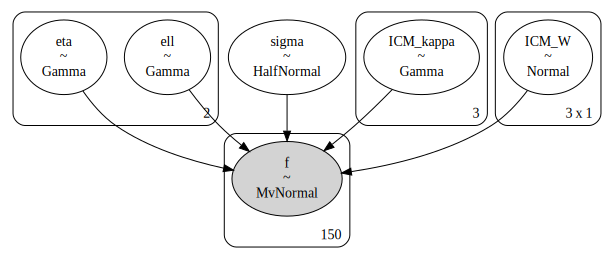

In [52]:
pm.model_to_graphviz(model)
# x1, y1
# x2, y2
# x3, y3

In [53]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 163 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 3min 35s, sys: 8min, total: 11min 35s
Wall time: 2min 50s


In [54]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 26.6 s, sys: 47.5 s, total: 1min 14s
Wall time: 20.3 s


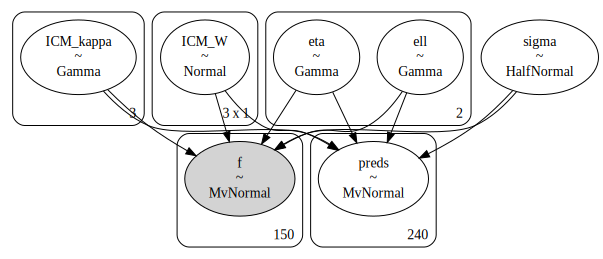

In [55]:
pm.model_to_graphviz(model)

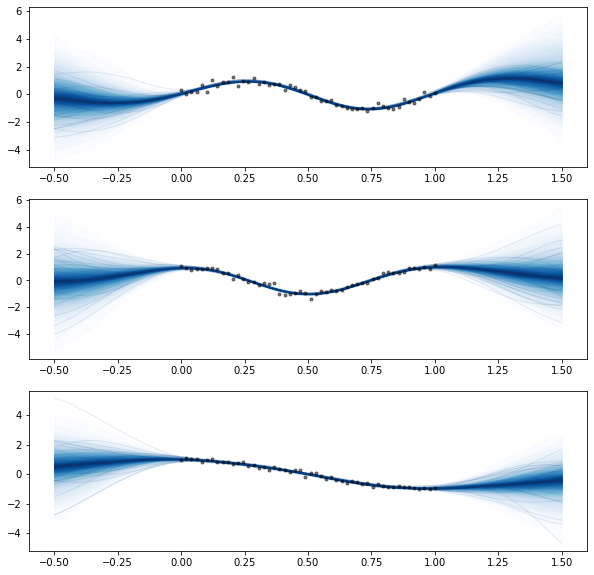

In [56]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [57]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_W[0, 0]",-0.204,2.482,-5.078,4.361,0.141,0.107,317.0,191.0,NaN
"ICM_W[1, 0]",0.090,2.427,-4.640,4.438,0.099,0.107,586.0,374.0,NaN
"ICM_W[2, 0]",-0.126,1.465,-2.827,2.573,0.083,0.073,356.0,233.0,NaN
ell[0],0.344,0.049,0.256,0.425,0.005,0.004,165.0,157.0,NaN
ell[1],4.657,2.764,0.893,9.815,0.125,0.089,430.0,278.0,NaN
eta[0],0.625,0.242,0.318,1.128,0.015,0.011,296.0,381.0,NaN
eta[1],0.749,0.595,0.069,1.794,0.032,0.023,348.0,311.0,NaN
sigma,0.156,0.010,0.135,0.171,0.000,0.000,448.0,241.0,NaN
ICM_kappa[0],5.055,2.337,0.938,8.987,0.095,0.067,458.0,238.0,NaN
ICM_kappa[1],5.189,2.114,1.948,9.278,0.114,0.082,369.0,374.0,NaN


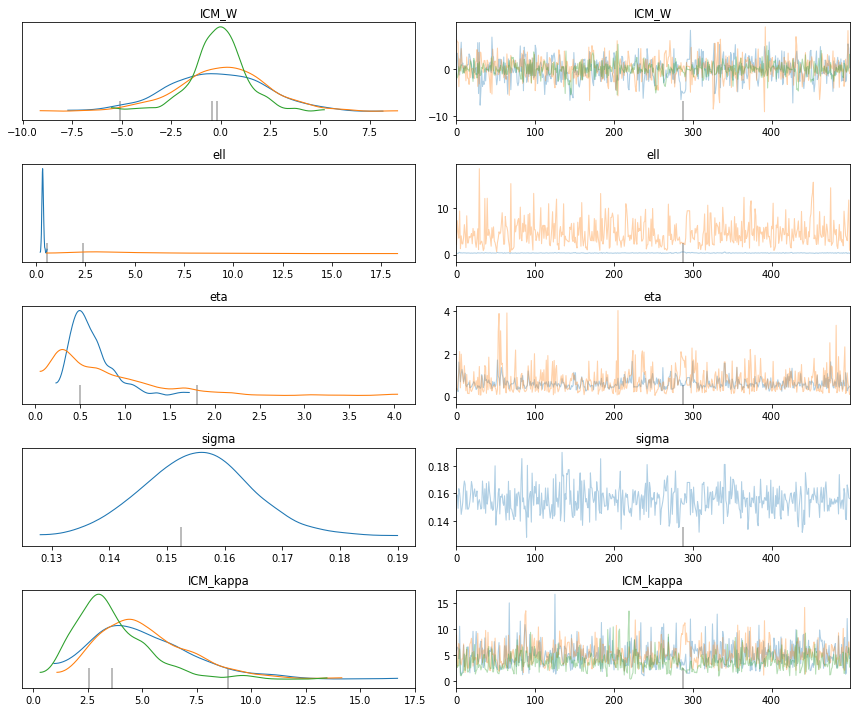

In [58]:
az.plot_trace(gp_trace);
plt.tight_layout()

In [59]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Sep 15 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

aesara    : 2.8.2
pymc      : 4.1.7
numpy     : 1.22.4
arviz     : 0.12.1
matplotlib: 3.5.2

Watermark: 2.3.0

